# Analyzing a Lennard-Jones fluid

This example will analyze a dump file from a simulation of simple liquid that
interacts via the Lennard-Jones pair potential: 

$$
u(r) = 4 \varepsilon \left[ \left(\frac{\sigma}{r} \right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]
$$

We've included the [LAMMPS input file](lammps_input.in) if you want to run the
simulation yourself, but we've also included the [dump](traj.lammpstrj.gz) file 
that we generated if you want to continue along now!

First, we import `lammpsio`.

In [13]:
import lammpsio

Dump files offer users flexibility in choosing what information to log, which
can make processing these files challenging. Luckily, `lammpsio` will
infer the format automatically! Alternatively, you can manually specify the
schema when reading the file. lammpsio can even load in a trajectory that has been 
written in gzip's compressed format! 

In [14]:
dump_file = lammpsio.DumpFile("traj.lammpstrj.gz")

## Calculating the radial distribution function

We will use the [freud](https://freud.readthedocs.io/en/latest/) package to
calculate the radial distribution function, $g(r)$, for our Lennard-Jones fluid.
Before continuing, make sure you have both freud and matplotlib installed. While
freud does not natively read LAMMPS files, it accepts particle coordinates as
NumPy arrays. `lammpsio` makes it easy to extract this data from LAMMPS dump
files!

We will evaluate $g(r)$ out to a distance of $3\,\sigma$ using a bin spacing of
$0.1\,\sigma$. freud assumes HOOMD-blue's convention for its box which differs
slightly from LAMMPS. lammpsio can take care of this conversion for you! 

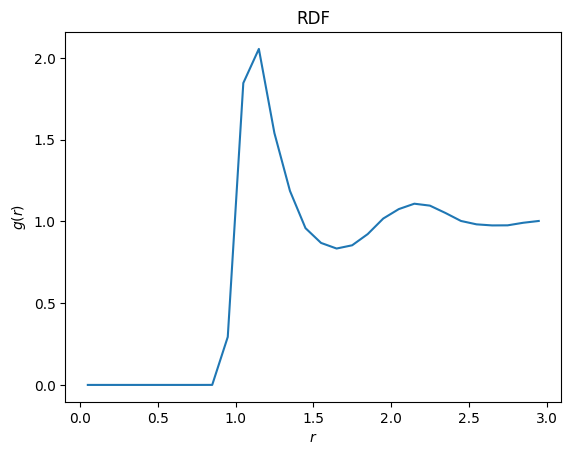

In [ ]:
import freud
import matplotlib.pyplot as plt

rdf = freud.density.RDF(bins=30, r_max=3.0)
for snapshot in dump_file:
    box = freud.box.Box.from_box(snapshot.box.to_hoomd_convention())
    rdf.compute((box, snapshot.position), reset=False)
rdf.plot();
plt.show();

This looks like a typical radial distrbution function for a liquid!

## Calculating the mean squared displacement

`freud` can also be used to compute the mean squared displacement of the
particles. For this computation, we need to unwrap the particle positions,
which we can also achieve using freud.

In [16]:
import numpy 

for i, snapshot in enumerate(dump_file):
    # allocate memory for whole trajectory on first pass
    if i == 0:
        positions = numpy.zeros((len(dump_file), snapshot.N, 3), dtype=float)

    # unwrap each snapshot using freud
    box = freud.box.Box.from_box(snapshot.box.to_hoomd_convention())
    positions[i] = box.unwrap(snapshot.position, snapshot.image)

Now we can calculate the mean squared displacement and plot the result! 

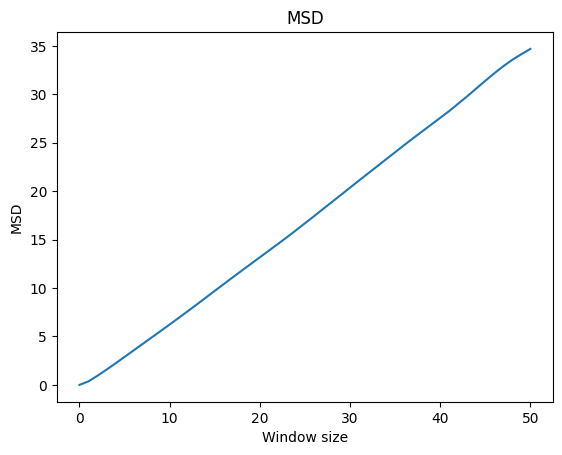

In [ ]:
msd = freud.msd.MSD(box)
msd.compute(positions)
msd.plot();
plt.show();